In [1]:
import os,sys,glob,traceback, pickle
from collections import Counter
import pandas as pd
import xarray as xr
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
files = glob.glob('../fair_temperatures/scen_*.csv')
scenarios = [fl.split('/scen_')[-1].split('.csv')[0] for fl in files]

In [3]:
year = 2050

In [4]:
# percentiles from MESMER-X
# these are the percentiles of fwixd for GMT values in 0.1K steps
# To get them I selected all values falling in the 0.1K GMT bin from the emulations available and computed the percentiles
# see mesmerX_example_preparation.py for details
percentiles = xr.open_dataarray('../fwixd.nc')

In [9]:
percentiles.loc[1.8, 70].values

array(43.4112324)

### Research question:
What are the emission constraints to avoid that the probability of 50 fwixd days in Portugal increases by a factor of 1.5? 

In [7]:
threshold = 50

In [8]:
# get current (GMT=1.2) probability of getting 50 fwixd days in a year in Portugal
p_current = 1 - percentiles.p.values[np.abs(percentiles.loc[1.2] - threshold).argmin()] / 100
p_current

0.13

In [9]:
# limit probability for the future
p_limit = 0.15

In [10]:
p_limit

0.15

In [12]:
# gmt for the 2237 runs of the 1500 tier2 scenarios in 2050
gmt = xr.open_dataset(f'gmt_in_{year}.nc')['gmt']

In [11]:
def prob_greater_at_gmt(g, thresh):
    '''
    returns the probability of staying below the threshold at given GMT g
    '''
    y = percentiles.sel(gmt=g, method='nearest')
    return 1 - percentiles.p.values[np.abs(y - thresh).argmin()] / 100

def prob_greater_in_scenario(scen, thresh):
    '''
    returns the probability of crossing thresh in given scenario
    '''
    # get all gmt values in 2050 from the 2237 runs
    # bin GMT in 0.1 K steps
    # and count occurences in bins
    counter = Counter(gmt.loc[scen].round(1).values)
    p = np.array([])
    # for each bin add the probability of crossing threshold at GMT level "count"-times
    for g,count in counter.items():
        p = np.append(p, [prob_greater_at_gmt(g, thresh)]*count)
    return p

In [13]:
# get probability of crossing crossing the threshold for each scenario
p_greater = xr.DataArray(dims=['scenario'], coords=dict(scenario=scenarios))
for scenario in scenarios:
    p_greater.loc[scenario] = prob_greater_in_scenario(scenario, threshold).mean()

In [14]:
# identify boundary scenarios that are close to the limit probability
boundary_scenarios = p_greater.scenario[np.abs(p_greater - p_limit) < 0.001]

In [21]:
gmt_median = xr.open_dataset('gmt_median.nc')['gmt']

In [50]:
# load fair emissions
emissions = pd.read_table('../Tier2_scenarios_emissions.csv', sep=',')
co2 = emissions.loc[(emissions.Variable == 'Emissions|CO2')]
co2 = xr.DataArray(co2.iloc[:,5:].values, dims=['scen','year'], coords=dict(scen=co2.Scenario, year=np.array(co2.columns[5:], 'int')))
ch4 = emissions.loc[(emissions.Variable == 'Emissions|CH4')]
ch4 = xr.DataArray(ch4.iloc[:,5:].values, dims=['scen','year'], coords=dict(scen=ch4.Scenario, year=np.array(ch4.columns[5:], 'int')))
cum_co2 = (co2.loc[:,2020:year].rolling(year=2).sum() * 0.5 * 10).sum('year') / 1000

In [118]:
# get cumulative CO2 emissions until 2050 in the orange scenario
CO2_budget = cum_co2.loc[boundary_scenarios].values.mean()
CO2_budget

437.53523800016046

'2030fact0.32_nz2050_ov0_meth0.25'

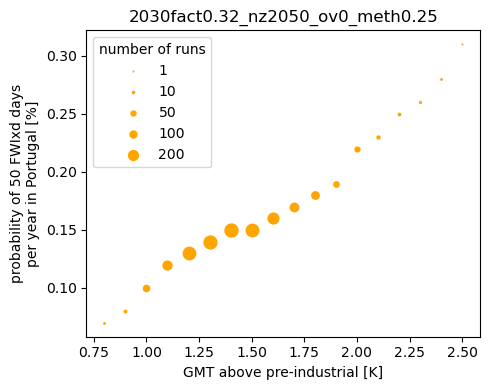

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(5,4), sharey=True)
scen = boundary_scenarios.values[5]
for g in np.unique(gmt.loc[scen].round(1).values):
    ax.scatter(g, prob_greater_at_gmt(g, threshold), color='orange', marker='.', s=np.sum(gmt.loc[scen].round(1).values==g))
for s in [1,10,50,100,200]:
    ax.scatter([],[], color='orange', marker='.', s=s, label=s)
ax.set_xlabel('GMT above pre-industrial [K]')
ax.set_ylabel('probability of 50 FWIxd days\nper year in Portugal [%]')
ax.set_title(scen)
ax.legend(title='number of runs')
plt.tight_layout()
plt.savefig('example_2.pdf')
plt.savefig('example_2.png', dpi=300)
scen

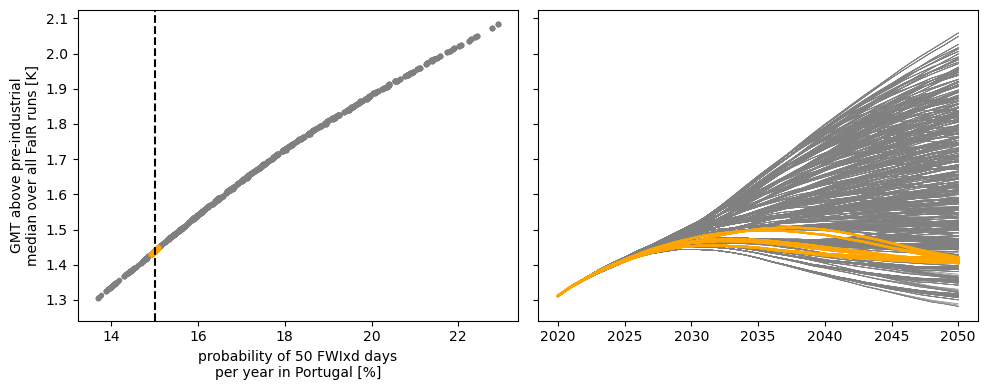

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
axes[0].scatter(p_greater.loc[:]*100, gmt.mean('run'), marker='.', color='gray')
axes[0].scatter(p_greater.loc[boundary_scenarios]*100, gmt.loc[boundary_scenarios].mean('run'), marker='.', color='orange')
axes[0].set_ylabel('GMT above pre-industrial\nmedian over all FaIR runs [K]')
axes[0].set_xlabel('probability of 50 FWIxd days\nper year in Portugal [%]')
axes[0].axvline(p_limit*100, color='k', linestyle='--')

for scen in gmt_median.scenario.values:
    axes[1].plot(gmt_median.loc[scen,2020:2050].year, gmt_median.loc[scen,2020:2050], color='gray', linewidth=0.5)
for scen in boundary_scenarios:
    axes[1].plot(gmt_median.loc[scen,2020:2050].year, gmt_median.loc[scen,2020:2050], color='orange')
plt.tight_layout()
plt.savefig('example_2.pdf')
plt.savefig('example_2.png', dpi=300)